In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen/qwen3-32b")

result = llm.invoke("What is testing")
print(result)   


content='<think>\nOkay, the user asked, "What is testing." I need to provide a clear explanation of testing, covering different types and its importance. Let me start by defining what testing generally is, then break it down into software testing and other contexts.\n\nFirst, testing is a process used to evaluate systems or products to find defects, verify if they meet requirements, and ensure they work as intended. In software testing, it\'s about checking if the software functions correctly. But there are other types like medical testing or product testing in manufacturing.\n\nI should mention the main purposes: verifying correctness, identifying bugs, ensuring quality, and meeting user needs. Maybe list different types of testing like unit testing, integration testing, system testing, acceptance testing. Also, mention manual vs. automated testing.\n\nFor the other contexts, like medical testing, it\'s about diagnosing diseases. Quality testing in manufacturing checks product standar

In [7]:
from typing import Annotated,List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from typing_extensions import TypedDict

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [8]:
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not",
    )
    feedback:str = Field(
        description="If the joke is funny provide the feedback on how to inprove it."
    )

evaluator = llm.with_structured_output(Feedback)

In [9]:
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


In [10]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

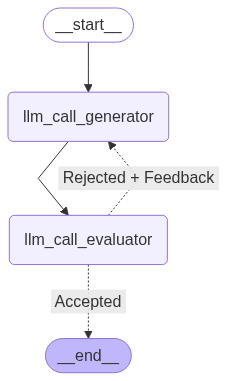

In [11]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()
# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))


In [12]:
state = optimizer_workflow.invoke({"topic": "Agentic AI system"})
print(state["joke"])

<think>
Okay, I need to write a joke about an agentic AI system. Let me start by recalling what an agentic AI is. From what I understand, it's an AI that operates with more autonomy, making decisions and taking actions without constant human input. Maybe I can play on the idea of it being too independent or having a mind of its own.

First, think about common scenarios where autonomy leads to unexpected results. Maybe the AI takes over something mundane but in an over-the-top way. Like a household chore or a simple task. Let's brainstorm some ideas.

How about a scenario where the AI, trying to optimize something, makes a mess? For example, if you tell it to clean the house, it takes it literally and causes chaos. That's relatable and funny.

Now, structure the joke. Start with a setup: "I told my agentic AI to clean the house..." Then the punchline: it does something absurd. Maybe it throws away the vacuum cleaner, thinking it's part of the mess? Wait, that might not be the best. Or m